In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import gridspec
rc('text', usetex=False)
plt.rcParams.update({'font.size': 8})
import scipy
from scipy.interpolate import Rbf, interp1d, griddata
from scipy.signal import find_peaks
import os
#plt.rcParams['figure.figsize'] = 5, 4

First define the update function for the ODEs

In [23]:
def step(p1, p2, p3, rr, t, gamma, alpha, n, Dt):
    # Compute growth rates on mesh
    mu = 0 #np.exp(-rr)
    # Update protein concs
    nextp1 = p1 + (alpha/(1 + p3**n) - gamma*p1 - mu*p1) * Dt
    nextp2 = p2 + (alpha/(1 + p1**n) - gamma*p2 - mu*p2) * Dt
    nextp3 = p3 + (alpha/(1 + p2**n) - gamma*p3 - mu*p3) * Dt
    deltar = np.zeros_like(rr)
    idx = np.where(rr>0)
    tau = -2 * np.log( np.exp( rr[idx] ) - 1 )
    deltar[idx] = np.log(1 + np.exp(0.5*(t + Dt - tau))) - np.log(1 + np.exp(0.5*(t-tau)))
    nextr = rr + deltar
    return nextp1, nextp2, nextp3, nextr

In [3]:
def step_simple(p1, p2, p3, gamma, alpha, n, Dt):
    # Update protein concs
    nextp1 = p1 + (alpha/(1 + p3**n) - gamma*p1) * Dt
    nextp2 = p2 + (alpha/(1 + p1**n) - gamma*p2) * Dt
    nextp3 = p3 + (alpha/(1 + p2**n) - gamma*p3) * Dt
    return nextp1, nextp2, nextp3

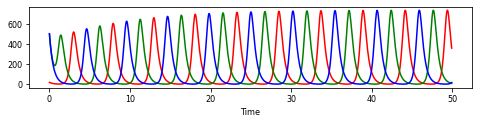

In [4]:
width = 2 * 85 / 25.4
height = 1.5 * 30 / 25.4
plt.figure(figsize=(width,height))

nx = 1
p1_list,p2_list,p3_list = [],[],[]
p1 = np.zeros((nx,))
p2  = np.zeros((nx,))
p3 = np.ones((nx,)) * 5.
for t in range(1000):
    p1,p2,p3 = step_simple(p1,p2,p3, 2, 1e4, 2, 0.05)
    p1_list.append(p1)
    p2_list.append(p2)
    p3_list.append(p3)

ap1 = np.array(p1_list)
ap2 = np.array(p2_list)
ap3 = np.array(p3_list)
t = np.arange(1000) * 0.05
plt.plot(t, ap1, 'r')
plt.plot(t, ap2, 'g')
plt.plot(t, ap3, 'b')

plt.xlabel('Time')
#plt.ylabel('Repressor')
#plt.xticks([])
#plt.yticks([])
plt.tight_layout()
plt.savefig('time_dynamics.png', dpi=300)

Next define a function to compute the kymograph by running simulations.

In [5]:
def compute_kymo(
    Dt = 0.05,
    gamma = 0.3,
    R0 = 1,
    alpha=1e4,
    n = 2,
    nx = 100,
    nt = 1000
):
  # Initial conditions on 1d mesh
  r = np.linspace(0,R0,nx, endpoint=True)
  t = 0
  p1 = np.zeros((nx,))
  p2  = np.zeros((nx,))
  p3 = np.ones((nx,)) * 5.
  p1_list = [p1] 
  p2_list = [p2]
  p3_list = [p3]
  r_list = [r]
  t_list = [[t]*nx]
  # Integrate equations forward
  for i in range(nt-1):
    ## Colony radius
    R = R0 + 0.5 * i * Dt

    # Integrate the ODEs
    p1,p2,p3,rnew = step(p1, p2, p3, r, i*Dt, gamma, alpha, n, Dt)

    #print(rnew.max())
    
    # New regular mesh in r axis
    new_mesh = np.linspace(0,R,nx, endpoint=True)

    # Interpolate result to regular mesh
    p1 = interp1d(rnew, p1, fill_value='extrapolate')(new_mesh)  
    p2 = interp1d(rnew, p2, fill_value='extrapolate')(new_mesh)  
    p3 = interp1d(rnew, p3, fill_value='extrapolate')(new_mesh)  

    p1_list.append(p1) 
    p2_list.append(p2) 
    p3_list.append(p3) 

    # Replace mesh for next iteration
    r = new_mesh
    r_list.append(r)  
    # Update time
    t = t + Dt
    t_list.append([t]*nx)

  # Make numpy arrays for convenience
  ap1 = np.array(p1_list).transpose()
  ap2 = np.array(p2_list).transpose()
  ap3 = np.array(p3_list).transpose()
  ar = np.array(r_list).transpose()
  at = np.array(t_list).transpose()

  # Remap kymograph to R coords = distance from center of colony
  R = R0 + at * 0.5
  aR = R - ar
  points = np.stack((at[:,::10].ravel(), aR[:,::10].ravel())).transpose()

  ti = np.linspace(0, at.max(), int(nt//10), endpoint=True)
  ri =  np.linspace(0, aR.max(), nx, endpoint=True)
  mti,mri = np.meshgrid(ti, ri)
  xi = np.stack((mti.ravel(),mri.ravel())).transpose()

  grid1 = griddata(points, ap1[:,::10].ravel(), xi, method='linear', fill_value=0)
  grid2 = griddata(points, ap2[:,::10].ravel(), xi, method='linear', fill_value=0)
  grid3 = griddata(points, ap3[:,::10].ravel(), xi, method='linear', fill_value=0)
  grid1 = grid1.reshape((nx,int(nt//10)))
  grid2 = grid2.reshape((nx,int(nt//10)))
  grid3 = grid3.reshape((nx,int(nt//10)))

  # Stack to get 3 channel normalized image
  kymo = np.stack((grid1/np.nanmax(grid1), grid2/np.nanmax(grid2), grid3/np.nanmax(grid3))).transpose()

  # Kymogroph in original relative coordinates, no remapped
  unmapped_kymo = np.stack((ap1[:,::10]/np.nanmax(ap1[:,::10]), 
                            ap2[:,::10]/np.nanmax(ap2[:,::10]), 
                            ap3[:,::10]/np.nanmax(ap3[:,::10]))).transpose()

  # Remove data from kymograph outside colony
  nkymo = np.zeros_like(kymo)
  nkymo[:,:,:] = kymo
  for i in range(nkymo.shape[0]):
    # Colony radius
    R = R0 + 0.5 * i * Dt * 10
    # Index into grid
    Ridx = int(R * nx / (R0 + 0.5 * nt * Dt))
    nkymo[i,Ridx+1:] = np.nan
  
  tscale = at.max()/nt*10
  rscale = aR.max()/nx
  return nkymo, unmapped_kymo, tscale, rscale

Now we make functions to compute the wavelength and wave speed of the travelling wave.

In [6]:
def compute_wave_length(unmapped_kymo, speed, tscale=1, debug=False):
  if debug:
    plt.figure()
    plt.imshow(unmapped_kymo, aspect='auto')

  mean_wave_lengths = []
  for c in range(3):
    # Take the wave at R=0
    signal = unmapped_kymo[:,0,c]
    pks,props = find_peaks(signal, prominence=0.1)
    if debug:
      plt.figure()
      plt.plot(signal)
      plt.plot(pks, signal[pks], '+')
    # Compute the frequency
    if len(pks)>1:
      # Compute average period
      mean_period = np.mean(np.diff(pks)) * tscale
      mean_freq = 1 / mean_period
      mean_wave_length = (speed + 0.5) / mean_freq
      mean_wave_lengths.append(mean_wave_length)
  return np.mean(mean_wave_lengths)

def compute_wave_speed(nkymo, dt=1, tscale=1, rscale=1, debug=False):
  if debug:
    plt.figure()
    plt.imshow(nkymo)

  # Find peaks in radial axis
  pks_list = []
  for channel in range(3):
    for i in range(1, nkymo.shape[0], 1):
      nk = nkymo[i,1:-1,channel]
      idx = ~np.isnan(nk) # times when both signals are within the colony
      nk = nk[idx]
      pks,props = find_peaks(nk, prominence=0.1)
      #print(props['peak_heights'])
      # Trim off end points
      tpks = []
      for p in pks:
        if p>1 and p<len(nk)-5:
          tpks.append(p)
          if debug:
            plt.plot(p, i, '.w')
      pks_list.append(tpks)

  # Track peaks from one timepoint to next +dt
  speeds = []
  for i in range(len(pks_list)-dt):
    pks = pks_list[i]
    # Peaks at next time point
    next_pks = pks_list[i+dt]
    for pk in pks:
      # Find closest peak at next time point
      min_dist = 10
      for next_pk in next_pks:
        if next_pk<=pk:
          dist = np.abs(next_pk-pk)
          if dist<min_dist:
            min_dist = dist
      # Make a threshold to avoid wrap around effects
      if min_dist<10:
        speed = min_dist*rscale / (dt*tscale)
      else:
        speed = np.nan
      speeds.append(speed)
      
  # Average of speeds of peaks, make sure we have enough data for estimate
  if len(speeds)>5:
    mean_speed = np.nanmean(speeds)
  else:
    mean_speed = np.nan

  nt,nx = nkymo.shape[:2]
  x1 = nt*mean_speed/rscale*tscale
  y1 = nx/mean_speed*rscale/tscale
  if debug:
      if x1<nx:
        plt.plot([0,x1], [nt,0], 'w')
      elif y1<nt:
        plt.plot([0,nx], [y1,0], 'w')

  #print('Mean wave speed = ', mean_speed)
  return mean_speed

We need to define a new function to compute the wavelength for CM simulations because we have no unmapped kymograph. Here we find the leading edge of the colony directly from the kymograph, with NaN outside the colonny.

In [7]:
def signal_at_edge(nkymo, channel, tscale=1, rscale=1, debug=False):
    if debug:
        plt.figure()
        plt.imshow(nkymo, aspect='auto')

    nt,nx = nkymo.shape[:2]
    signal = []
    start_time = 0
    for t in range(nt):
        idx = np.where(~np.isnan(nkymo[t,:,channel]))[0]
        if len(idx)>0:
            last_idx = idx[-1] # position of edge of colony at time t
            signal.append(nkymo[t,last_idx,channel])
            if debug:
                plt.plot(last_idx, t, 'w.')
        else:
            # This will find the first time at which the colony has non-zero radius
            start_time = t
    # Compute mean speed of front, this will give inaccurate wavelength 
    # estimates if the colony is not growing linearly
    avg_front_speed = last_idx * rscale / (nt-start_time) / tscale
    return np.array(signal), avg_front_speed

def compute_wave_length_CM(nkymo, speed, tscale=1, rscale=1, debug=False):
  mean_wave_lengths = []
  for c in range(3):
    # Take the wave at r=0
    signal, front_speed = signal_at_edge(nkymo, c, tscale=tscale, rscale=rscale, debug=debug)
    if len(signal)>2:
        pks,props = find_peaks(signal, prominence=0.1)
        if debug:
          plt.figure()
          plt.plot(signal)
          plt.plot(pks, signal[pks], '+')
        # Compute the frequency
        if len(pks)>1:
          # Compute average period
          mean_period = np.mean(np.diff(pks)) * tscale
          mean_freq = 1 / mean_period
          mean_wave_length = (speed + front_speed) / mean_freq
          mean_wave_lengths.append(mean_wave_length)
  return np.mean(mean_wave_lengths)

In [8]:
def reflect_kymo(kymo):
    rkymo = np.concatenate((kymo[:,::-1,:],kymo), axis=1)
    return rkymo

In [9]:
def plot_kymo(kymo, tscale, rscale, tick_step_t, tick_step_r, reflect=False):
    tick_step_t = min(tick_step_t, int(kymo.shape[0]*tscale))
    nticks = kymo.shape[0] * tscale // tick_step_t + 1
    ticks = np.arange(0, nticks) * tick_step_t / tscale
    tick_labels = np.arange(0, nticks) * tick_step_t
    tick_labels = ['%d'%label for label in tick_labels]
    plt.xticks(ticks, tick_labels)

    if reflect:
        kymo = reflect_kymo(kymo)
        lim = int(kymo.shape[1] * rscale / 2)
        left = np.flip(np.append(np.arange(0, lim, tick_step_r), lim))
        right = np.append(np.arange(0, lim, tick_step_r), lim)
        tick_labels = np.append(left, right)
        tick_labels = np.delete(tick_labels, len(tick_labels)//2)
        ticks = np.linspace(0,kymo.shape[1]-1, len(tick_labels)).astype(int).tolist()
    
    else:
        tick_step_r = min(tick_step_r, int(kymo.shape[1]*rscale))
        nticks = kymo.shape[1] * rscale // tick_step_r + 1
        ticks = np.arange(0, nticks) * tick_step_r / rscale
        tick_labels = np.arange(0, nticks) * tick_step_r
        tick_labels = ['%d'%label for label in tick_labels]
    
    plt.yticks(ticks, tick_labels)
    plt.imshow(kymo.transpose(1,0,2), aspect='auto')

Here we construct phase space plots for wave speed and wavelength depending on the parameters gamma, mu0, d, and k.

First consider gamma and d, with mu0=1 and k=0.1

In [ ]:
speeds = []
wavelengths = []
wavelengths_orig = []
ngammas = 25
nalphas = 25
gammas = np.logspace(-3, 0, ngammas, endpoint=True)
alphas = np.logspace(2, 5, nalphas, endpoint=True)
plt.figure(figsize=(7,7))
i = 1
for gammai in gammas:
    for alphai in alphas:
        nkymo,unmapped_kymo,tscale,rscale = compute_kymo(gamma=gammai, alpha=alphai, nx=400, Dt=0.05)
        speed = compute_wave_speed(nkymo, tscale=tscale, rscale=rscale)
        wavelength_orig = compute_wave_length(unmapped_kymo, speed, tscale=tscale)
        wavelength = compute_wave_length_CM(nkymo, speed, tscale=tscale, rscale=rscale)
        speeds.append(speed)
        wavelengths.append(wavelength)
        wavelengths_orig.append(wavelength_orig)
        #plt.subplot(ngammas, nalphas, i)
        #plt.imshow(nkymo, aspect='auto')
        #plt.title(r'$\gamma=%g$, $\alpha=%g$'%(gammai, alphai))
        #plt.xticks([])
        #plt.yticks([])
        i += 1
        #print('speed=%02f, wavelength=%02f, gamma=%02f, mu0=%02f'%(speed, wavelength/rscale, gammai, 1))

# Convert the results to arrays and reshape to the grid
aspeeds = np.array(speeds)
aspeeds = aspeeds.reshape((ngammas,nalphas))
awavelengths = np.array(wavelengths)
awavelengths = awavelengths.reshape((ngammas,nalphas))
awavelengths_orig = np.array(wavelengths_orig)
awavelengths_orig = awavelengths_orig.reshape((ngammas,nalphas))

Plot the resulting phase space.

In [267]:
#---
# Wavelength
plt.figure(figsize=(60/25.4,60/25.4))
plt.imshow(awavelengths, origin='lower', cmap='plasma')

plt.xlabel(r'$\alpha$')
xstep = 24/3
ticks = [0, xstep, xstep*2, 24]
tick_labels = ['$10^{%d}$'%val for val in [2, 3, 4, 5]]
plt.xticks(ticks, tick_labels, rotation=90)

plt.ylabel(r'$\bar\gamma$')
#plt.yticks(np.arange(ngammas)[::1], np.round(gammas[::1],2))
ystep = 24/3
ticks = [0, ystep, ystep*2, 24]
tick_labels = ['$10^{%d}$'%val for val in [-3, -2, -1, 0]]
plt.yticks(ticks, tick_labels)

plt.colorbar()
plt.title(r'Wavelength $\lambda$')

plt.subplots_adjust(left=0.25, right=0.9)
plt.savefig('heatmap_wavelength.png', dpi=300)
plt.show()

#---
# Wave speed
plt.figure(figsize=(60/25.4,60/25.4))
plt.imshow(aspeeds, origin='lower', cmap='plasma')

plt.xlabel(r'$\alpha$')
xstep = 24/3
ticks = [0, xstep, xstep*2, 24]
tick_labels = ['$10^{%d}$'%val for val in [2, 3, 4, 5]]
plt.xticks(ticks, tick_labels, rotation=90)

plt.ylabel(r'$\bar\gamma$')
#plt.yticks(np.arange(ngammas)[::1], np.round(gammas[::1],2))
ystep = 24/3
ticks = [0, ystep, ystep*2, 24]
tick_labels = ['$10^{%d}$'%val for val in [-3, -2, -1, 0]]
plt.yticks(ticks, tick_labels)
plt.colorbar()
plt.title('Wave speed $v_p$')

plt.subplots_adjust(left=0.25, right=0.9)
plt.savefig('heatmap_wavespeed.png', dpi=300)
plt.show()

#print(awavelengths.max())
#print(gammas)

NameError: name 'awavelengths' is not defined

In [123]:
print(alphas)

[   100.            133.35214322    177.827941      237.13737057
    316.22776602    421.69650343    562.34132519    749.89420933
   1000.           1333.52143216   1778.27941004   2371.37370566
   3162.27766017   4216.96503429   5623.4132519    7498.94209332
  10000.          13335.21432163  17782.79410039  23713.73705662
  31622.77660168  42169.65034286  56234.13251903  74989.42093325
 100000.        ]


In [169]:
gammas = np.linspace(0,2,10)
alphas = [1e2, 1e3, 1e4, 1e5]
speeds_list = []
gammas_list = []
for alpha in alphas:
    print(alpha)
    speeds = []
    for gamma in gammas:
        nkymo,unmapped_kymo,tscale,rscale = compute_kymo(gamma=gamma, alpha=alpha, nx=400)
        speed = compute_wave_speed(nkymo, tscale=tscale, rscale=rscale)
        speeds.append(speed)
    speeds_list.append(speeds)
    gammas_list.append(gammas)
aspeeds2 = np.array(speeds_list)
agammas2 = np.array(gammas_list)

100.0
1000.0
10000.0
100000.0


[[0.         0.22222222 0.44444444 0.66666667 0.88888889 1.11111111
  1.33333333 1.55555556 1.77777778 2.        ]
 [0.         0.22222222 0.44444444 0.66666667 0.88888889 1.11111111
  1.33333333 1.55555556 1.77777778 2.        ]
 [0.         0.22222222 0.44444444 0.66666667 0.88888889 1.11111111
  1.33333333 1.55555556 1.77777778 2.        ]
 [0.         0.22222222 0.44444444 0.66666667 0.88888889 1.11111111
  1.33333333 1.55555556 1.77777778 2.        ]]
[[0.02375337 0.13062704 0.24833176 0.37082781 0.500732   0.63263893
  0.76862431 0.90336277 1.01448652 1.07137733]
 [0.02747794 0.1298526  0.2455812  0.36314731 0.48629367 0.60898624
  0.73475242 0.85827804 0.97535775 1.05920866]
 [0.03180974 0.13580018 0.25076608 0.36881855 0.49229383 0.61506394
  0.73469934 0.84939512 0.95700019 1.0521049 ]
 [0.03128576 0.13300842 0.25020261 0.37388657 0.50334603 0.63545787
  0.76313511 0.87948086 0.97142629 1.0559738 ]]


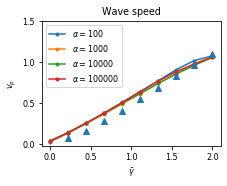

[0.53456706 0.02139926]


In [266]:
plt.figure(figsize=(90/25.4,65/25.4))

print(agammas2)
print(aspeeds2)

plt.gca().set_prop_cycle(None)
plt.plot(agammas2.transpose(), aspeeds2.transpose(), '.-');

Tint = aperiods2 * 0.05
Text = aperiods2_ext * 0.05
ws = 0.5*Text/(Tint-Text)
plt.gca().set_prop_cycle(None)
plt.plot(agammas2[0,:].transpose(), ws[0,:].transpose(), '^');

plt.xlabel(r'$\bar\gamma$')
plt.ylabel(r'$v_p$')
plt.yticks([0, 0.5, 1, 1.5])
plt.legend([r'$\alpha=%g$'%alpha for alpha in [1e2, 1e3, 1e4, 1e5]])
plt.subplots_adjust(bottom=0.2)
plt.subplots_adjust(left=0.2)

plt.title('Wave speed')
plt.savefig('line_plot_wave_speed.png', dpi=300)
plt.show()

p = np.polyfit(agammas2.ravel(), aspeeds2.ravel(), deg=1)
print(p)

In [209]:
alphas = np.logspace(2,5,10)
gammas = [1e-3, 1e-2, 1e-1, 1e0]
wavelengths_list = []
alphas_list = []
for gamma in gammas:
    print(gamma)
    wavelengths = []
    for alpha in alphas:
        nkymo,unmapped_kymo,tscale,rscale = compute_kymo(gamma=gamma, alpha=alpha, nx=400)
        speed = compute_wave_speed(nkymo, tscale=tscale, rscale=rscale)
        wavelength = compute_wave_length_CM(nkymo, speed, tscale, rscale)
        wavelengths.append(wavelength)
    wavelengths_list.append(wavelengths)
    alphas_list.append(alphas)
awavelengths2 = np.array(wavelengths_list)
aalphas2 = np.array(alphas_list)

0.001
0.01
0.1
1.0


(4, 10)
(4, 10)
[[       nan        nan        nan 2.35728472]
 [       nan        nan        nan 2.71472386]
 [       nan        nan        nan 3.14254873]
 [       nan        nan        nan 3.60975   ]
 [       nan        nan        nan 4.1469544 ]
 [       nan        nan        nan 4.74391428]
 [       nan        nan        nan 5.38132767]
 [       nan        nan        nan 6.06222386]
 [       nan        nan        nan 6.69747557]
 [       nan        nan        nan 7.4116242 ]]
[0.001, 0.01, 0.1, 1.0]
[1.00984293 0.99787283]


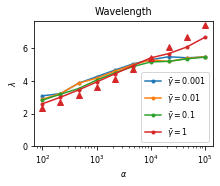

In [265]:
plt.figure(figsize=(90/25.4,65/25.4))

print(aalphas2.shape)
print(awavelengths2.shape)

plt.gca().set_prop_cycle(None)
plt.plot(aalphas2.transpose(), awavelengths2.transpose(), '.-');

Tint = aperiods3 * 0.05
Text = aperiods3_ext * 0.05
wl = 0.5*Text*Tint/(Tint-Text)
plt.gca().set_prop_cycle(None)
plt.plot(aalphas2.transpose(), wl, '^');
print(wl)
print(gammas)

plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\lambda$')
plt.yticks([0, 2, 4, 6])
plt.legend([r'$\bar\gamma=%g$'%g for g in gammas])
plt.subplots_adjust(bottom=0.2)
plt.subplots_adjust(left=0.2)

plt.title('Wavelength')
plt.savefig('line_plot_wavelength.png', dpi=300)

p = np.polyfit(np.log10(aalphas2.ravel()), awavelengths2.ravel(), deg=1)
print(p)

#plt.figure()
#plt.plot(awavelengths2.transpose()/10, aalphas2.transpose(), '.-');
#plt.plot(alphas, np.log10(alphas) + 1.36, 'k--')
plt.show()

In [235]:
def compute_period(signal):
    mean_periods = []
    for c in range(3):
        sig = signal[c][:,0]
        nsig = sig/sig.max()
        if len(nsig)>2:
            pks,props = find_peaks(nsig, prominence=0.1)
            # Compute the frequency
            if len(pks)>1:
                # Compute average period
                mean_period = np.mean(np.diff(pks))
                mean_periods.append(mean_period)
    return np.mean(mean_periods)

In [247]:
alphas = [1e2, 1e3, 1e4, 1e5]
periods_list = []
periods_ext_list = []
gammas_list = []
r = np.linspace(0,0,nx)
for alpha in alphas:
    print(alpha)
    periods = []
    periods_ext = []
    for gamma in agammas2[0,:]:
        # Simulate repressilator at fixed mu with different gamma
        nx = 1
        p1_list,p2_list,p3_list = [],[],[]
        p1 = np.zeros((nx,))
        p2  = np.zeros((nx,))
        p3 = np.ones((nx,)) * 5.
        r = np.linspace(0,0,nx)
        for t in range(1000):
            p1,p2,p3 = step_simple(p1,p2,p3,gamma, alpha, 2, 0.05)
            p1_list.append(p1)
            p2_list.append(p2)
            p3_list.append(p3)
        ap1 = np.array(p1_list)
        ap2 = np.array(p2_list)
        ap3 = np.array(p3_list)
        period = compute_period([ap1,ap2,ap3])
        periods.append(period)
        
        # Exterior region with gamma+1
        p1_list,p2_list,p3_list = [],[],[]
        p1 = np.zeros((nx,))
        p2  = np.zeros((nx,))
        p3 = np.ones((nx,)) * 5.
        r = np.linspace(0,0,nx)
        for t in range(1000):
            p1,p2,p3 = step_simple(p1,p2,p3, gamma+1, alpha, 2, 0.05)
            p1_list.append(p1)
            p2_list.append(p2)
            p3_list.append(p3)
        ap1 = np.array(p1_list)
        ap2 = np.array(p2_list)
        ap3 = np.array(p3_list)
        period = compute_period([ap1,ap2,ap3])
        periods_ext.append(period)
    periods_list.append(periods)
    periods_ext_list.append(periods_ext)
    gammas_list.append(gammas)
aperiods2 = np.array(periods_list)
aperiods2_ext = np.array(periods_ext_list)

100.0


/Users/timrudge/anaconda2/envs/spatialoscillator/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/timrudge/anaconda2/envs/spatialoscillator/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1000.0
10000.0
100000.0


In [248]:
aperiods2

array([[         nan, 647.5       , 276.5       , 163.86666667,
        114.98809524,  88.66666667,  72.73931624,  61.95555556,
         54.35294118,  48.52982456],
       [         nan, 854.        , 399.        , 249.66666667,
        177.78333333, 138.44444444, 113.27380952,  96.3       ,
         84.17575758,  74.88247863],
       [         nan,          nan, 441.        , 293.55555556,
        221.38888889, 178.61666667, 150.47777778, 130.41269841,
        115.13690476, 103.08796296],
       [         nan,          nan, 450.        , 306.33333333,
        237.22222222, 195.83333333, 170.03333333, 150.58888889,
        135.72222222, 124.28571429]])

In [250]:
gammas = [1e-3, 1e-2, 1e-1, 1e0]
periods_list = []
periods_ext_list = []
gammas_list = []
r = np.linspace(0,0,nx)
for alpha in aalphas2[0,:]:
    print(alpha)
    periods = []
    periods_ext = []
    for gamma in gammas:
        # Simulate repressilator at fixed mu with different gamma
        nx = 1
        p1_list,p2_list,p3_list = [],[],[]
        p1 = np.zeros((nx,))
        p2  = np.zeros((nx,))
        p3 = np.ones((nx,)) * 5.
        r = np.linspace(0,0,nx)
        for t in range(1000):
            p1,p2,p3 = step_simple(p1,p2,p3, gamma, alpha, 2, 0.05)
            p1_list.append(p1)
            p2_list.append(p2)
            p3_list.append(p3)
        ap1 = np.array(p1_list)
        ap2 = np.array(p2_list)
        ap3 = np.array(p3_list)
        period = compute_period([ap1,ap2,ap3])
        periods.append(period)
        
        # Exterior region with gamma+1
        p1_list,p2_list,p3_list = [],[],[]
        p1 = np.zeros((nx,))
        p2  = np.zeros((nx,))
        p3 = np.ones((nx,)) * 5.
        r = np.linspace(0,0,nx)
        for t in range(1000):
            p1,p2,p3 = step_simple(p1,p2,p3, gamma+1, alpha, 2, 0.05)
            p1_list.append(p1)
            p2_list.append(p2)
            p3_list.append(p3)
        ap1 = np.array(p1_list)
        ap2 = np.array(p2_list)
        ap3 = np.array(p3_list)
        period = compute_period([ap1,ap2,ap3])
        periods_ext.append(period)
    periods_list.append(periods)
    periods_ext_list.append(periods_ext)
    gammas_list.append(gammas)
aperiods3 = np.array(periods_list)
aperiods3_ext = np.array(periods_ext_list)

100.0
215.44346900318845


/Users/timrudge/anaconda2/envs/spatialoscillator/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/timrudge/anaconda2/envs/spatialoscillator/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


464.15888336127773
1000.0
2154.4346900318824
4641.588833612777
10000.0
21544.346900318822
46415.888336127726
100000.0


In [251]:
aperiods3

array([[         nan,          nan,          nan,  99.99537037],
       [         nan,          nan,          nan, 116.80357143],
       [         nan,          nan,          nan, 136.03968254],
       [         nan,          nan,          nan, 155.55555556],
       [         nan,          nan,          nan, 172.73333333],
       [         nan,          nan,          nan, 186.68333333],
       [         nan,          nan,          nan, 197.83333333],
       [         nan,          nan,          nan, 205.55555556],
       [         nan,          nan,          nan, 211.55555556],
       [         nan,          nan,          nan, 214.        ]])

(4, 10)
(4, 10)


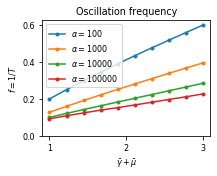

[[ 99.66666667  79.71212121  66.84065934  57.89583333  51.21247563
   46.04444444  41.96772069  38.57888889  35.76115859  33.32430213]
 [155.55555556 124.38095238 103.93981481  89.86666667  79.21969697
   71.02564103  64.43650794  58.99583333  54.43899782  50.56920078]
 [197.83333333 163.33333333 139.66666667 122.19047619 108.625
   97.92592593  89.13333333  81.72727273  75.47222222  70.1025641 ]
 [214.         182.48333333 159.66666667 142.73333333 130.12698413
  118.98214286 109.41666667 101.18055556  94.22962963  87.89090909]]


In [189]:
plt.figure(figsize=(85/25.4,60/25.4))

print(agammas2.shape)
print(aperiods2.shape)

plt.plot(agammas2.transpose()+1, 1/(aperiods2.transpose()*0.05), '.-');
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$\bar\gamma + \bar\mu$')
plt.ylabel(r'$f=1/T$')
#plt.ylim([0,0.01])
#plt.xlim([0,1])
plt.yticks([0, 0.2, 0.4, 0.6])
plt.xticks([1, 2, 3])
plt.legend([r'$\alpha=%g$'%a for a in alphas])
plt.subplots_adjust(bottom=0.2)
plt.subplots_adjust(left=0.2)

plt.title('Oscillation frequency')
plt.savefig('line_plot_waveperiod.png', dpi=300)

#p = np.polyfit(np.log10(agammas2.ravel()), aperiods2.ravel(), deg=1)
#print(p)

#plt.figure()
#plt.plot(awavelengths2.transpose()/10, aalphas2.transpose(), '.-');
#plt.plot(alphas, np.log10(alphas) + 1.36, 'k--')
plt.show()

print(aperiods2)

[[0.         0.22222222 0.44444444 0.66666667 0.88888889 1.11111111
  1.33333333 1.55555556 1.77777778 2.        ]
 [0.         0.22222222 0.44444444 0.66666667 0.88888889 1.11111111
  1.33333333 1.55555556 1.77777778 2.        ]
 [0.         0.22222222 0.44444444 0.66666667 0.88888889 1.11111111
  1.33333333 1.55555556 1.77777778 2.        ]
 [0.         0.22222222 0.44444444 0.66666667 0.88888889 1.11111111
  1.33333333 1.55555556 1.77777778 2.        ]]
nan
nan
0.07019533543256658
2.2725739846293425
0.1594030085434247
2.2037465931128466
0.27316871780757285
2.2381623612367134
0.40509697389890753
2.3176128360888986
0.5436633828685924
2.402745032559693
0.6846805808852827
2.4859171859834888
0.8251580398307902
2.5561562389424926
0.9644588106081945
2.6185371890630327
1.0957960272383516
2.6589394478480073
0.0


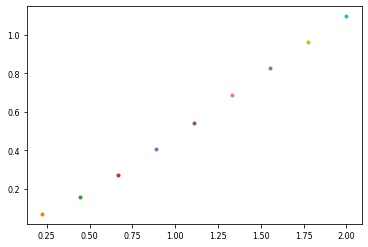

In [163]:
print(agammas2)
for i in range(10):
    Tint = aperiods2[0,i] * 0.05
    Text = aperiods2_ext[0,i] * 0.05
    ws = 0.5*Text/(Tint-Text)
    print(ws)
    wl = 0.5*Text*Tint/(Tint-Text)
    print(wl)
    plt.plot(agammas2[0,i], ws, '.')
    
print(agammas2[0,0])

Create an example kymograph for illustration

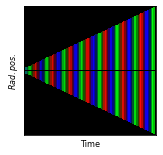

In [24]:
plt.figure(figsize=(60/25.4, 60/25.4))
nkymo,unmapped_kymo,tscale,rscale = compute_kymo(gamma=1.5, alpha=1e4, nx=400, Dt=0.05, nt=1000)
plot_kymo(nkymo, tscale, rscale, tick_step_t=50, tick_step_r=20, reflect=True)
plt.xlabel('Time')
plt.ylabel('$Rad. pos.$')
plt.xticks([])
plt.yticks([])
#plt.subplots_adjust(bottom=0.2)
plt.savefig('example_kymo_diagonal.png', dpi=300)

Let look at some kymographs for limiting cases of the parameters mu0 and gamma.

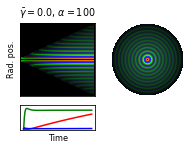

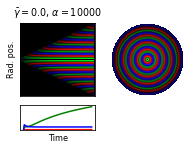

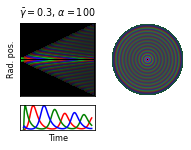

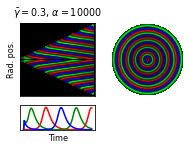

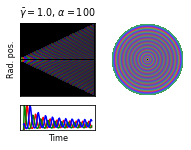

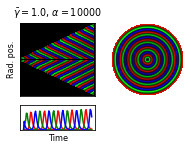

In [192]:
gammas = [0, 0.3, 1]
alphas = [1e2, 1e4]
for gamma in gammas:
    for alpha in alphas:
        fig = plt.figure(figsize=(75/25.4, 50/25.4)) 
        gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[3,1]) 

        ax0 = plt.subplot(gs[0,0])
        nkymo,unmapped_kymo,tscale,rscale = compute_kymo(gamma=gamma, alpha=alpha, nx=400, Dt=0.05, nt=1000)
        plot_kymo(nkymo, tscale, rscale, tick_step_t=10, tick_step_r=10, reflect=True)
        plt.xlabel('')
        plt.ylabel('Rad. pos.')
        plt.xticks([])
        plt.yticks([])
        plt.title(r'$\bar \gamma = %0.1f$, $\alpha = %d$'%(gamma,alpha))

        ax1 = plt.subplot(gs[0,1])
        '''
        rkymo = reflect_kymo(nkymo)
        nx = rkymo.shape[1]
        r = np.arange(-nx//2, nx//2)*rscale
        ax1.plot(rkymo[-2,:,0], r, 'r')
        ax1.plot(rkymo[-2,:,1], r, 'g')
        ax1.plot(rkymo[-2,:,2], r, 'b')
        ax1.set_xlim([0,1])
        ax1.set_xticks([])
        ax1.set_yticks([])
        '''
        rmax = nkymo.shape[1]
        x = np.arange(rmax*2) - rmax
        x,y = np.meshgrid(x,x)
        r = np.sqrt(x*x + y*y).astype(np.int32)
        r[r>=rmax] = -1
        nkymo_r = nkymo[-2,:,0]
        nkymo_g = nkymo[-2,:,1]
        nkymo_b = nkymo[-2,:,2]

        nkymo_rad = np.stack((nkymo_r[r], nkymo_g[r], nkymo_b[r])).transpose()
        nkymo_rad = nkymo_rad/np.nanmax(nkymo_rad)
        nkymo_rad[np.isnan(nkymo_rad)] = 1
        ax1.imshow(nkymo_rad)
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.axis('off')

        ax2 = plt.subplot(gs[1,0])
        nt = nkymo.shape[0]
        t = np.arange(0,nt-2)
        ax2.plot(t, nkymo[:-2,1,0], 'r')
        ax2.plot(t, nkymo[:-2,1,1], 'g')
        ax2.plot(t, nkymo[:-2,1,2], 'b')
        plt.xlabel('Time')
        ax2.set_ylim([0,1])
        ax2.set_xticks([])
        ax2.set_yticks([])
        
        plt.savefig('gamma_%0.1f_alpha_%0.1f.png'%(gamma,alpha), dpi=300)


0.03 1000000.0
kymo_0.03_1000000.0.npy
0.7 100.0
kymo_0.7_100.0.npy
1.5 100000.0
kymo_1.5_100000.0.npy
1.2 100000.0
kymo_1.2_100000.0.npy
0.03 100.0
kymo_0.03_100.0.npy
0.3 100000.0
kymo_0.3_100000.0.npy
0.5 100000.0
kymo_0.5_100000.0.npy
1.5 100.0
kymo_1.5_100.0.npy
0.5 1000000.0
kymo_0.5_1000000.0.npy
0.03 10000.0
kymo_0.03_10000.0.npy
1.2 100.0
kymo_1.2_100.0.npy
1.5 10000.0
kymo_1.5_10000.0.npy
0.3 1000.0
kymo_0.3_1000.0.npy
1.5 1000000.0
kymo_1.5_1000000.0.npy
1.2 1000000.0
kymo_1.2_1000000.0.npy
1.0 10000.0
kymo_1.0_10000.0.npy
0.7 10000.0
kymo_0.7_10000.0.npy
0.0 10000.0
kymo_0.0_10000.0.npy
0.5 1000.0
kymo_0.5_1000.0.npy
0.5 100.0
kymo_0.5_100.0.npy
0.01 10000.0
kymo_0.01_10000.0.npy


<ipython-input-115-28a56d34da61>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(3, 2))
<ipython-input-115-28a56d34da61>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(3, 2))


1.0 1000.0
kymo_1.0_1000.0.npy
0.3 100.0
kymo_0.3_100.0.npy


<ipython-input-115-28a56d34da61>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(3, 2))
<ipython-input-115-28a56d34da61>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(3, 2))


1.2 10000.0
kymo_1.2_10000.0.npy
1.5 1000.0
kymo_1.5_1000.0.npy


<ipython-input-115-28a56d34da61>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(3, 2))


0.5 10000.0
kymo_0.5_10000.0.npy


<ipython-input-115-28a56d34da61>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(3, 2))


1.0 1000000.0
kymo_1.0_1000000.0.npy
0.03 100000.0
kymo_0.03_100000.0.npy


<ipython-input-115-28a56d34da61>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(3, 2))
<ipython-input-115-28a56d34da61>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(3, 2))


0.7 1000.0
kymo_0.7_1000.0.npy
1.0 100.0
kymo_1.0_100.0.npy


<ipython-input-115-28a56d34da61>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(3, 2))
<ipython-input-115-28a56d34da61>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(3, 2))


1.2 1000.0
kymo_1.2_1000.0.npy


<ipython-input-115-28a56d34da61>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(3, 2))


0.03 1000.0
kymo_0.03_1000.0.npy


<ipython-input-115-28a56d34da61>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(3, 2))


0.7 100000.0
kymo_0.7_100000.0.npy


<ipython-input-115-28a56d34da61>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(3, 2))


0.7 1000000.0
kymo_0.7_1000000.0.npy


<ipython-input-115-28a56d34da61>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(3, 2))


0.3 1000000.0
kymo_0.3_1000000.0.npy
1.0 100000.0
kymo_1.0_100000.0.npy


<ipython-input-115-28a56d34da61>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(3, 2))
<ipython-input-115-28a56d34da61>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(3, 2))


0.3 10000.0
kymo_0.3_10000.0.npy


<ipython-input-115-28a56d34da61>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(3, 2))


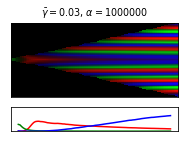

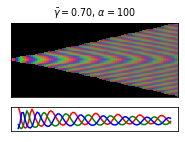

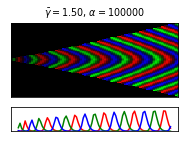

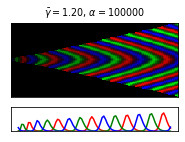

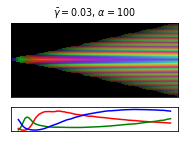

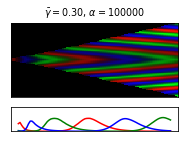

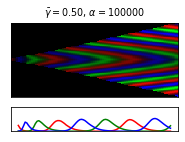

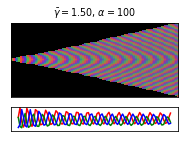

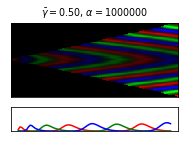

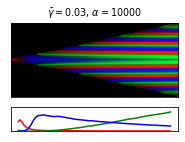

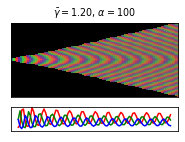

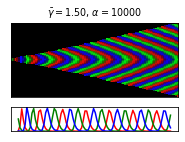

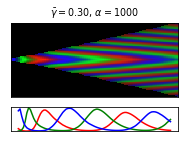

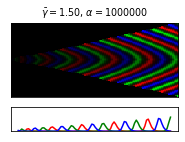

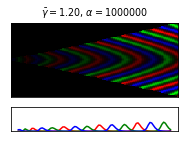

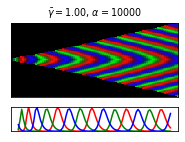

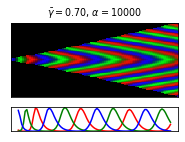

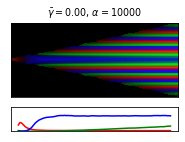

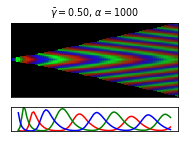

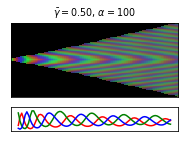

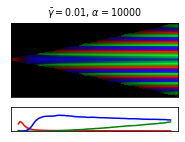

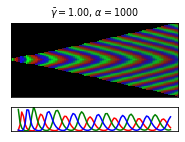

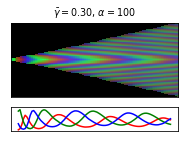

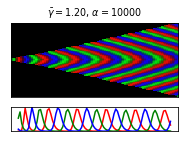

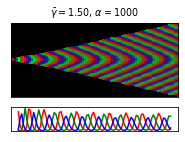

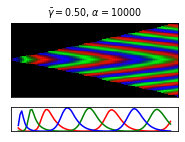

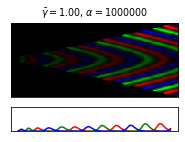

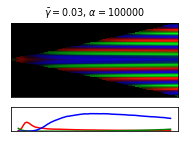

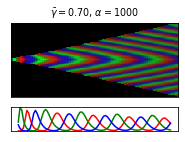

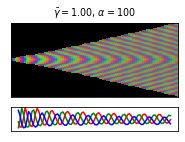

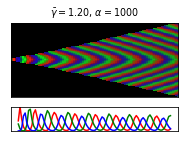

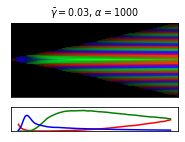

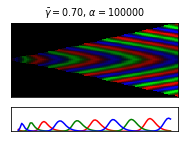

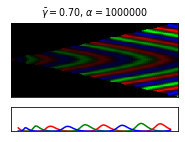

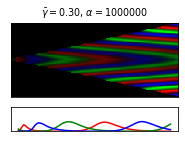

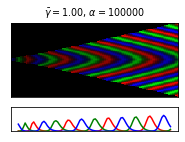

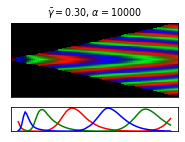

In [115]:
kymopath = 'kymos'
filenames = os.listdir(kymopath)
for fname in filenames:
    split = fname.split('_')
    gamma = float(split[1])
    d = float(split[2].split('.')[0])
    print(gamma, d)
    
    nkymo = np.load(os.path.join(kymopath, fname))
    nkymo = nkymo[10:,:,:]
    print(fname)
    
    fig = plt.figure(figsize=(3, 2)) 
    gs = gridspec.GridSpec(2, 1, height_ratios=[3,1]) 

    ax0 = plt.subplot(gs[0,0])
    plot_kymo(nkymo, tscale, rscale/10, tick_step_t=10, tick_step_r=10, reflect=True)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([])
    plt.yticks([])
    plt.title(r'$\bar \gamma=%0.2f$, $\alpha=%d$'%(gamma,d))

    '''
    ax1 = plt.subplot(gs[0,1])
    rkymo = reflect_kymo(nkymo)
    nx = rkymo.shape[1]
    r = np.arange(-nx//2, nx//2)*rscale
    ax1.plot(rkymo[-2,:,0], r, 'r')
    ax1.plot(rkymo[-2,:,1], r, 'g')
    ax1.plot(rkymo[-3,:,2], r, 'b')
    ax1.set_xlim([0,1])
    ax1.set_xticks([])
    ax1.set_yticks([])
    '''
    
    ax2 = plt.subplot(gs[1,0])
    nt = nkymo.shape[0]
    t = np.arange(0,nt-2)
    ax2.plot(t, nkymo[:-2,1,0], 'r')
    ax2.plot(t, nkymo[:-2,1,1], 'g')
    ax2.plot(t, nkymo[:-2,1,2], 'b')
    #plt.xlabel('Time')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_ylim([0,1])

    plt.savefig('%s.png'%(fname), dpi=300)



0.03 1000000.0
kymo_0.03_1000000.0.npy
0.7 100.0
kymo_0.7_100.0.npy
1.5 100000.0
kymo_1.5_100000.0.npy
1.2 100000.0
kymo_1.2_100000.0.npy
0.03 100.0
kymo_0.03_100.0.npy
0.3 100000.0
kymo_0.3_100000.0.npy
0.5 100000.0
kymo_0.5_100000.0.npy
1.5 100.0
kymo_1.5_100.0.npy
0.5 1000000.0
kymo_0.5_1000000.0.npy
0.03 10000.0
kymo_0.03_10000.0.npy
1.2 100.0
kymo_1.2_100.0.npy
1.5 10000.0
kymo_1.5_10000.0.npy
0.3 1000.0
kymo_0.3_1000.0.npy
1.5 1000000.0
kymo_1.5_1000000.0.npy
1.2 1000000.0
kymo_1.2_1000000.0.npy
1.0 10000.0
kymo_1.0_10000.0.npy
0.7 10000.0
kymo_0.7_10000.0.npy
0.0 10000.0
kymo_0.0_10000.0.npy
0.5 1000.0
kymo_0.5_1000.0.npy
0.5 100.0
kymo_0.5_100.0.npy
0.01 10000.0
kymo_0.01_10000.0.npy
1.0 1000.0
kymo_1.0_1000.0.npy


<ipython-input-212-92fd6a249f74>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(60/25.4, 45/25.4))


0.3 100.0
kymo_0.3_100.0.npy
1.2 10000.0
kymo_1.2_10000.0.npy
1.5 1000.0
kymo_1.5_1000.0.npy
0.5 10000.0
kymo_0.5_10000.0.npy
1.0 1000000.0
kymo_1.0_1000000.0.npy
0.03 100000.0
kymo_0.03_100000.0.npy
0.7 1000.0
kymo_0.7_1000.0.npy
1.0 100.0
kymo_1.0_100.0.npy
1.2 1000.0
kymo_1.2_1000.0.npy
0.03 1000.0
kymo_0.03_1000.0.npy
0.7 100000.0
kymo_0.7_100000.0.npy
0.7 1000000.0
kymo_0.7_1000000.0.npy
0.3 1000000.0
kymo_0.3_1000000.0.npy
1.0 100000.0
kymo_1.0_100000.0.npy
0.3 10000.0
kymo_0.3_10000.0.npy


<Figure size 432x288 with 0 Axes>

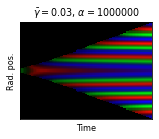

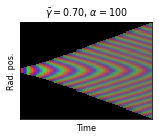

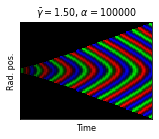

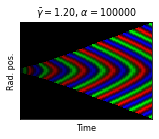

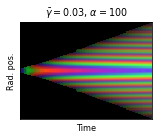

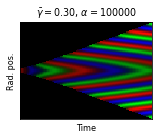

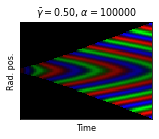

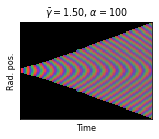

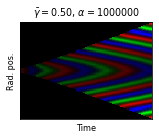

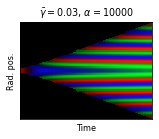

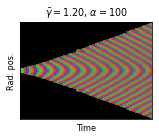

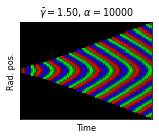

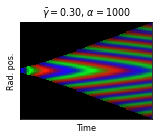

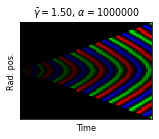

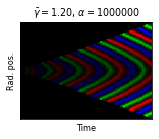

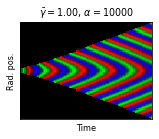

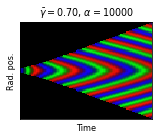

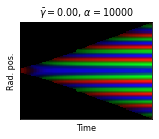

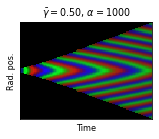

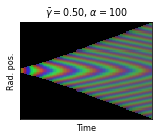

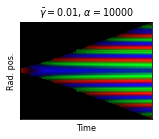

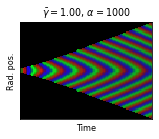

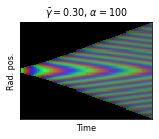

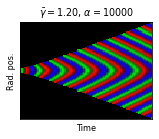

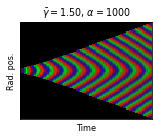

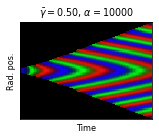

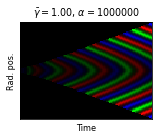

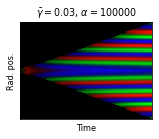

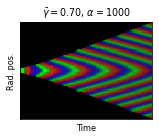

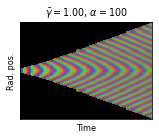

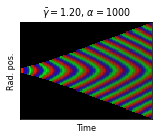

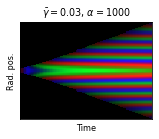

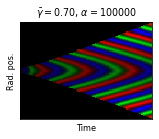

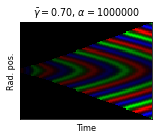

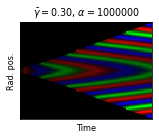

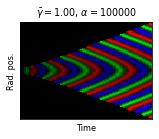

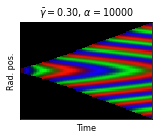

In [212]:
plt.figure()

kymopath = 'kymos'
filenames = os.listdir(kymopath)
for fname in filenames:
    split = fname.split('_')
    gamma = float(split[1])
    d = float(split[2].split('.')[0])
    print(gamma, d)
    
    nkymo = np.load(os.path.join(kymopath, fname))
    nkymo = nkymo[10:,:,:]
    print(fname)
    
    fig = plt.figure(figsize=(60/25.4, 45/25.4)) 
    plot_kymo(nkymo, tscale, rscale/10, tick_step_t=10, tick_step_r=10, reflect=True)
    plt.xlabel('Time')
    plt.ylabel('Rad. pos.')
    plt.xticks([])
    plt.yticks([])
    plt.title(r'$\bar \gamma=%0.2f$, $\alpha=%d$'%(gamma,d))

    plt.savefig('%s.png'%(fname), dpi=300)

In [122]:
nkymo.shape

(92, 46, 3)

Convert the kymograph to a radial pattern for illustration

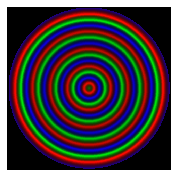

In [193]:
plt.figure(figsize=(3,3))

nkymo,unmapped_kymo,tscale,rscale = compute_kymo(gamma=1.5, alpha=1e4, nx=400, Dt=0.05, nt=1000)

rmax = nkymo.shape[1]
x = np.arange(rmax*2) - rmax
x,y = np.meshgrid(x,x)
r = np.sqrt(x*x + y*y).astype(np.int32)
r[r>=rmax] = -1
nkymo_r = nkymo[-2,:,0]
nkymo_g = nkymo[-2,:,1]
nkymo_b = nkymo[-2,:,2]

nkymo_rad = np.stack((nkymo_r[r], nkymo_g[r], nkymo_b[r])).transpose()
nkymo_rad[np.isnan(nkymo_rad)] = 0
plt.imshow(nkymo_rad)
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.savefig('1d_pattern.png', dpi=300)

Using the debug flag we can check the intermediate computations to make sure our analysis is correct.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6.083567541900877 68.80757898351551
0.499499999999993 1.2987499999999823


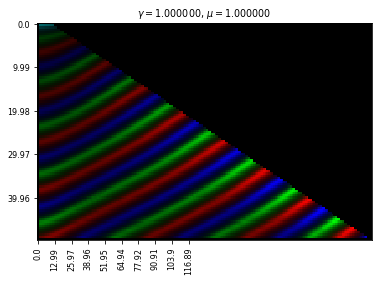

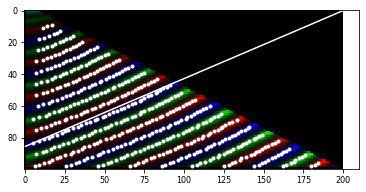

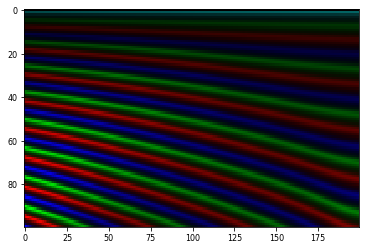

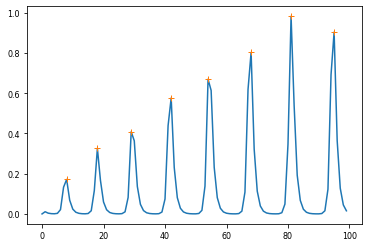

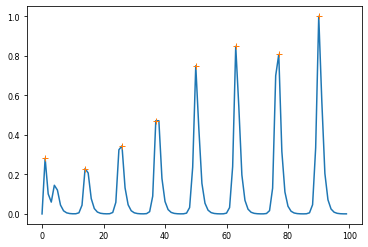

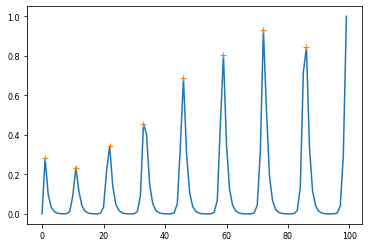

In [415]:
gamma = 1
alpha = 1e5


nkymo,unmapped_kymo,tscale,rscale = compute_kymo(gamma=gamma, alpha=alpha, Dt=0.05, nx=400)
plt.imshow(nkymo, aspect='auto')
plt.xticks(np.arange(0,100,10), np.round(np.arange(0,100,10)*rscale, 2), rotation=90)
plt.yticks(np.arange(0,100,20), np.round(np.arange(0,100,20)*tscale, 2))
plt.title('$\gamma = %02f$, $\mu = %02f$'%(gamma, mu0))

speed = compute_wave_speed(nkymo, tscale=tscale, rscale=rscale, debug=True)
wavelength = compute_wave_length(unmapped_kymo, speed, tscale=tscale, mu0=mu0, k=k, debug=True)
print(speed, wavelength)
print(tscale, rscale)

Check our results against those of CellModeller simulations.

In [145]:
cm_analysis = np.load('analysis.npy')
cm_analysis.shape
print(cm_analysis[:,0])
import pandas as pd
df = pd.DataFrame(cm_analysis.transpose(), columns=['gamma', 'alpha', 'wavespeed', 'wavelength'])

[3.00000000e-02 1.00000000e+02 1.70278638e-01 2.66803833e+01]


In [146]:
cm_gammas = cm_analysis[0,:]
cm_alphas = cm_analysis[1,:]
cm_speeds = cm_analysis[2,:]
cm_wavelengths = cm_analysis[3,:]
print(cm_gammas)
print(cm_alphas)

[0.03 0.03 0.03 0.03 0.03 0.3  0.3  0.3  0.3  0.3  0.5  0.5  0.5  0.5
 0.5  0.7  0.7  0.7  0.7  0.7  1.   1.   1.   1.   1.   1.2  1.2  1.2
 1.2  1.2  1.5  1.5  1.5  1.5  1.5 ]
[1.e+02 1.e+03 1.e+04 1.e+05 1.e+06 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06
 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06
 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06
 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06]


In [201]:
speeds = []
wavelengths = []
wavelengths_orig = []
nsims = len(cm_gammas)
for i in range(nsims):
    nkymo,unmapped_kymo,tscale,rscale = compute_kymo(gamma=cm_gammas[i], alpha=cm_alphas[i], nx=400)
    #plot_kymo(nkymo, tscale, rscale/10, tick_step_t=10, tick_step_r=10, reflect=True)
    speed = compute_wave_speed(nkymo, tscale=tscale, rscale=rscale, debug=False)
    wavelength = compute_wave_length_CM(nkymo, speed, tscale=tscale, rscale=rscale, debug=False)
    wavelength_orig = compute_wave_length(unmapped_kymo, speed, tscale=tscale, debug=False)
    speeds.append(speed)
    wavelengths.append(wavelength)
    wavelengths_orig.append(wavelength_orig)
speeds = np.array(speeds)
wavelengths = np.array(wavelengths)
wavelengths_orig = np.array(wavelengths_orig)

[11.57062027 -0.245716  ] [0.09130491 0.04583256]


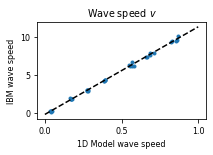

In [203]:
plt.figure(figsize=(85/25.4, 50/25.4))
plt.plot(speeds, cm_speeds, '.')
plt.xlabel('1D Model wave speed')
plt.ylabel('IBM wave speed')
plt.yticks([0,5,10])
plt.xticks([0,0.5,1])

p,cov = np.polyfit(speeds, cm_speeds, 
                    deg=1, cov=True)
print(p, np.sqrt(np.diag(cov)))
plt.plot([0,1], [p[1],p[1]+1*p[0]], 'k--')

plt.title('Wave speed $v$')
plt.subplots_adjust(left=0.2, bottom=0.2)
plt.savefig('wave_speed_comparison.png', dpi=300)

[9.00752319 6.49388911] [0.41704835 2.33334709]


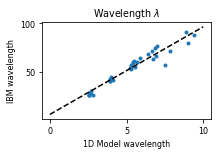

In [204]:
plt.figure(figsize=(85/25.4, 50/25.4))
plt.plot(wavelengths, cm_wavelengths, '.')
plt.xlabel('1D Model wavelength')
plt.ylabel('IBM wavelength')
plt.xticks([0,5,10])
plt.yticks([0,50,100])

p,cov = np.polyfit(wavelengths, cm_wavelengths, 
                    deg=1, cov=True)
print(p, np.sqrt(np.diag(cov)))
plt.plot([0,10], [p[1],p[1]+10*p[0]], 'k--')

plt.subplots_adjust(left=0.2, bottom=0.2)
plt.title('Wavelength $\lambda$')
plt.savefig('wavelength_comparison.png', dpi=300)

[10.0350336   0.80865545]
[0.13967194 0.55112366]


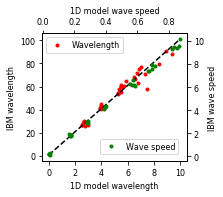

In [173]:
p = np.polyfit(np.concatenate((wavelengths, speeds)), 
                    np.concatenate((cm_wavelengths, cm_speeds)), 
                    deg=1, cov=True)
print(p[0])
print(np.sqrt(np.diag(p[1])))
slope = p[0][0]
intercept = p[0][1]

fig,ax = plt.subplots(1, figsize=(85/25.4, 75/25.4))

ax.plot(wavelengths, cm_wavelengths, 'r.')
ax.set_xlabel('1D model wavelength')
ax.set_ylabel('IBM wavelength')
ax.legend(['Wavelength'])
ax.plot([0,10], [intercept, intercept + slope*10], 'k--')

ax_twiny = ax.twiny()
ax_twiny.set_xlabel('1D model wave speed')
ax_twinxy = ax_twiny.twinx()
ax_twinxy.plot(speeds, cm_speeds, 'g.')
ax_twinxy.set_ylabel('IBM wave speed')
ax_twinxy.legend(['Wave speed'], loc=(0.4,0.05))

plt.subplots_adjust(left=0.2, right=0.8, bottom=0.2, top=0.8)
plt.savefig('wavelength_speed_comparison.png', dpi=300)

In [111]:
C_wavelength = np.corrcoef(wavelengths, cm_wavelengths)
C_speed = np.corrcoef(speeds, cm_speeds)
print(np.sqrt(C_wavelength[0,1]))
print(np.sqrt(C_speed[0,1]))

NameError: name 'wavelengths' is not defined

In [256]:
hgammas = np.logspace(-3, 0, 20, endpoint=True)
hds = np.logspace(1, 5, 20, endpoint=True)
grid_ds, grid_gammas = np.meshgrid(hds, hgammas)

'\nfig,ax = plt.subplots(1)\ngamma_groups = df.groupby(\'gamma\')\nlegend = []\nfor gamma,g in gamma_groups:\n    ax.plot(g[\'alpha\'], g[\'wavelength\'], \'+\')\n    ax.set(xscale="log")\n    legend.append(r\'$\x08ar\\gamma = %g$\'%gamma)\nplt.legend(legend)\n'

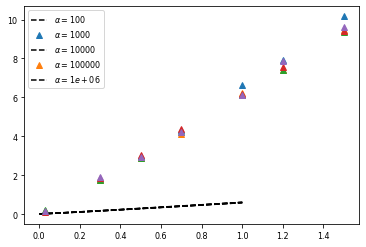

In [257]:
import seaborn as sns
fig,ax = plt.subplots(1)
alpha_groups = df.groupby('alpha')
legend = []
speeds_1d = []
for alpha,g in alpha_groups:
    speeds = []
    for gamma in hgammas:
        nkymo,unmapped_kymo,tscale,rscale = compute_kymo(gamma=gamma, mu0=1, d=alpha, nx=200)
        speed = compute_wave_speed(nkymo, tscale=tscale, rscale=rscale/10, debug=False)
        speeds.append(speed)
    speeds_1d.append(speeds)
    ax.plot(hgammas, speeds, 'k--')
    ax.plot(g['gamma'], g['wavespeed'], '^')
    ax.set(xscale="linear")
    legend.append(r'$\alpha = %g$'%alpha)
plt.legend(legend)
'''
fig,ax = plt.subplots(1)
gamma_groups = df.groupby('gamma')
legend = []
for gamma,g in gamma_groups:
    ax.plot(g['alpha'], g['wavelength'], '+')
    ax.set(xscale="log")
    legend.append(r'$\bar\gamma = %g$'%gamma)
plt.legend(legend)
'''

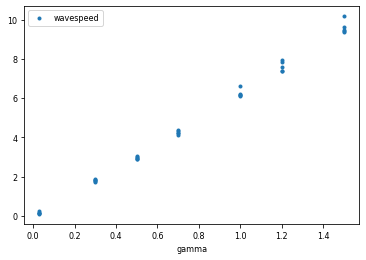

In [380]:
df.plot(x='gamma', y='wavespeed', style='.')

gamma
0.03    AxesSubplot(0.125,0.125;0.775x0.755)
0.30    AxesSubplot(0.125,0.125;0.775x0.755)
0.50    AxesSubplot(0.125,0.125;0.775x0.755)
0.70    AxesSubplot(0.125,0.125;0.775x0.755)
1.00    AxesSubplot(0.125,0.125;0.775x0.755)
1.20    AxesSubplot(0.125,0.125;0.775x0.755)
1.50    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

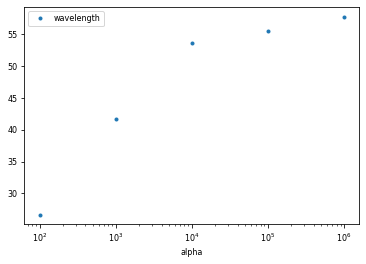

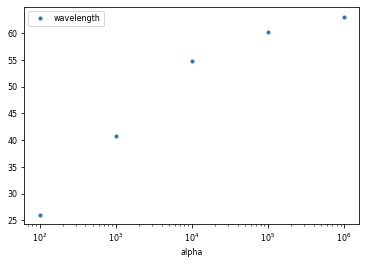

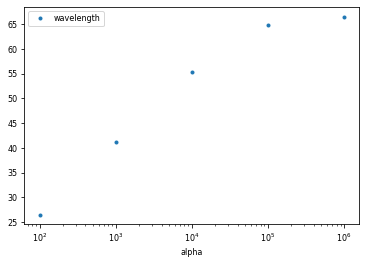

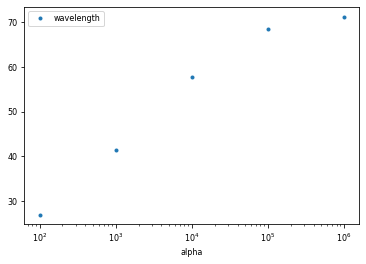

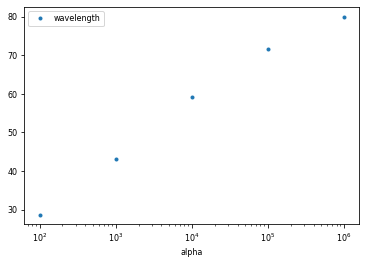

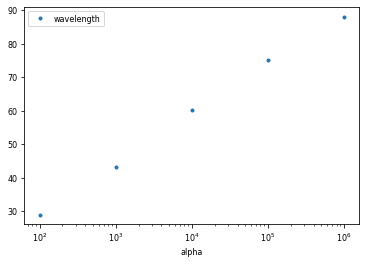

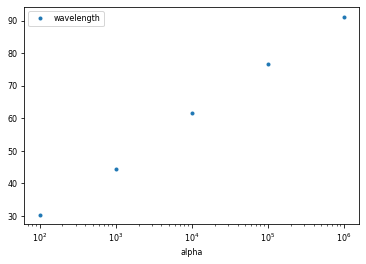

In [383]:
df.groupby('gamma').plot(x='alpha', y='wavelength', style='.', logx=True)